# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


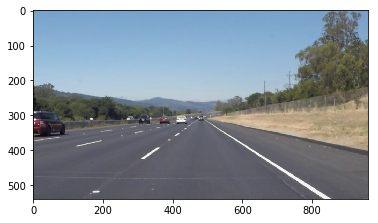

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [76]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny_param(img, params):
    return canny(img, params['low_canny'],params['high_canny'])
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def blur(img, params):
    return gaussian_blur(img, params['kernel'])

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    #cv2.fillPoly(mask, vertices, ignore_mask_color)
    cv2.fillPoly(mask, np.int_([vertices]), ignore_mask_color)
    
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 255], thickness=3):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
                   
        #for x1,y1,x2,y2 in line:
        line = np.reshape(line,(4,))
        x1 = line[0]
        y1 = line[1]
        x2 = line[2]
        y2 = line[3]
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def hough_param(img, params):
    """
    'img' should be the output of a Canny transform
    Returns an image with hough lines drawn. 
    """
    return hough_lines(img, params['rho'],params['theta'],
                       params['hough_threshold'],
                       params['min_line_length'],
                       params['max_gap'], 
                       params['min_slope'],
                       params['height_ratio'] )

def line_angle(line):
    """find slope of a line
    Line is defined as [x1,y1,x2,y2]
    returns angle in radians """
    lf = line.reshape((4,))
    
    dx = lf[2]-lf[0]
    dy = lf[3]-lf[1]
    return np.arctan2(dx,dy)


def regress_line(lines):
    """Fit a regression line to all the endpoints in the given lines.
    Uses equation from https://en.wikipedia.org/wiki/Simple_linear_regression """
    xs = []
    ys = []
    for line in lines:
        lf = line.reshape((4,))
        xs.append(lf[0])
        ys.append(lf[1])
        xs.append(lf[2])
        ys.append(lf[3])
    xar = np.array(xs)
    yar = np.array(ys)
    avg_x  = np.mean(xar)
    avg_y = np.mean(yar)
    std_x = np.std(xar)
    std_y = np.std(yar)
    count = np.shape(xar)[0]
    #print('count %i' % count)
    
    sumNumerator = 0
    sumDenomenator = 0
    for idx in range(count):
        xi = xar[idx]
        yi = yar[idx]
        rx = xi-avg_x
        ry = yi-avg_y
        sumNumerator = sumNumerator + rx*ry
        sumDenomenator = sumDenomenator + rx*rx
        
    slope = sumNumerator / sumDenomenator
    intercept = avg_y - slope* avg_x
    
    return (slope,intercept, np.min(yar))

def get_x(slope,intercept,y):
    """get the x value of a line, given its slope and intercept"""
    return (y-intercept)/slope
    
def merge_lines(lines, ymax,y_topregion):
    """Merge lines. These lines have already been sorted by positive/negative slope, so they should be mergeable"""
    
    (slope,intercept,ymin) = regress_line(lines)
    x_bottom = get_x(slope,intercept,ymax)
    x_top = get_x(slope,intercept,y_topregion)
    
    if x_bottom == float('inf') or x_bottom == float('-inf'):
        return None
    if x_top == float('inf') or x_top == float('-inf'):
        return None
    
    return [int(x_bottom), int(ymax), int(x_top),int(y_topregion)]
    

def process_lines(lines, min_slope, size_y, y_top_roi):
    
    # separate lines by slope into left and right, with a threshold on the slope angle. Too flat is an invalid line
    left_lines = []
    right_lines = []
    left_count = 0
    right_count = 0
    
    for line in lines:
        # calculate the line angle
        angle = line_angle(line)
                
        # don't use the line if it is too flat
        if np.abs(angle) < min_slope or np.abs(angle-np.pi) < min_slope:
            print('rejected line with angle {} deg'.format(angle*180/np.pi))
            continue
            
        if angle > np.pi/2: # if angle is less than pi/2 (90 degrees) then it is a left line
            left_lines.append(line)            
            left_count += 1
        else: # then it is a right line
            right_lines.append(line)            
            right_count += 1            
            
    #print('left: %i' % left_count)
    #print('right: %i' % right_count)
        
    # run linear regression on left lines and right lines to find single line for each side
 
    result = []
    
    if left_count > 0:
        merged = merge_lines(left_lines, size_y,y_top_roi)
        if merged is not None:
            result.append(np.array(merged))
    if right_count > 0:
        merged = merge_lines(right_lines,size_y,y_top_roi)
        if merged is not None:
            result.append(np.array(merged))
        
    return result

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, min_slope, height_ratio):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    size_y = img.shape[0]
    processed_lines = process_lines(lines, min_slope, size_y, size_y * height_ratio)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    raw_line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, processed_lines)
    draw_lines(raw_line_img, lines)
    return (line_img, raw_line_img)

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [37]:
import os
os.listdir("test_images/")

['solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg']

In [72]:
import os
def get_image_names():
    return os.listdir("test_images/")

In [88]:
def load_image(name):
    return mpimg.imread('test_images/' + name)

def view_image(image):
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    
def write_image(image, name, output_dir):
    """ Write image to output folder """
    
    mpimg.imsave(output_dir + '/' + name,image)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

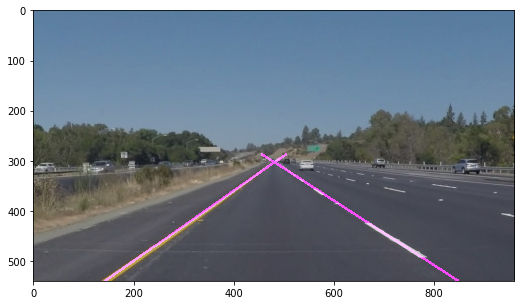

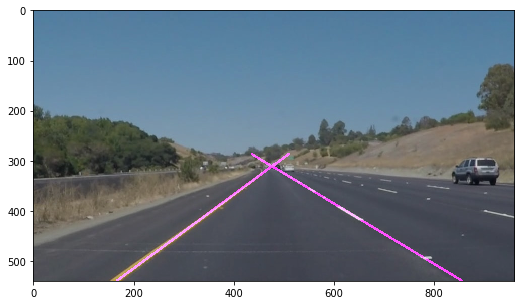

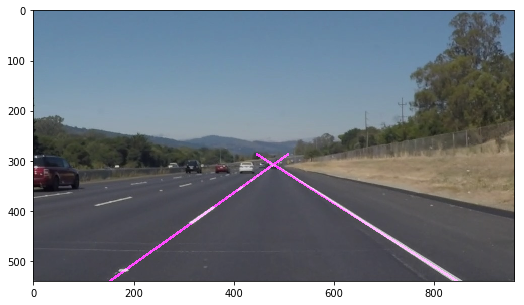

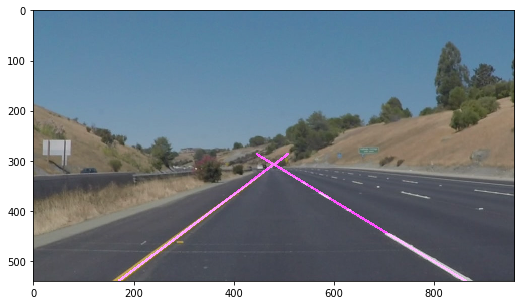

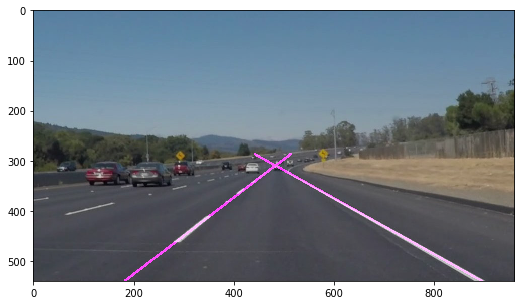

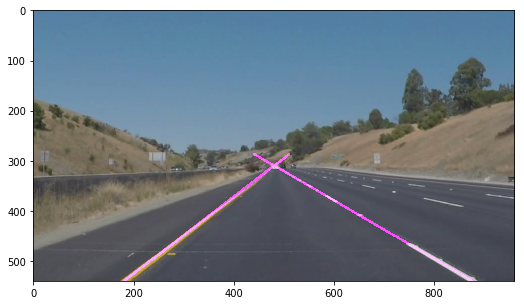

In [90]:



def display_lane_set(img_set):
    plt.figure(figsize=(50,20))
    #plt.subplot(1,1,1)
    #plt.imshow(img_set['original'])
    plt.subplot(1,5,2)
    #plt.imshow(img_set['gray'],cmap=plt.cm.gray)
    #plt.subplot(1,5,3)
    #plt.imshow(img_set['blurred'],cmap=plt.cm.gray)
    #plt.subplot(1,4,2)
    #plt.imshow(img_set['canny'])
    #plt.subplot(1,4,1)
    #plt.imshow(img_set['hough_raw'])
    #plt.subplot(1,4,2)
    #plt.imshow(img_set['hough_raw'])
    #plt.subplot(1,4,3)
    #plt.imshow(img_set['hough'])
    #plt.subplot(1,4,4)
    plt.imshow(img_set['applied'])
   
    
    
def get_vertices(image, params):
    # Grab the x and y sizes 
    ysize = image.shape[0]
    xsize = image.shape[1]
    
    # define a quadrilateral region of interest    
    x = np.array([[params['offset'], ysize], [xsize-params['offset'], ysize],
                  [ xsize/2-params['center_width']/2, ysize*params['height_ratio']],
                 [ xsize/2+params['center_width']/2, ysize*params['height_ratio']]], np.int32)
    
    return x
    

def get_parameters():
    params = {}
    params['rho'] = 1
    params['theta'] = np.pi / 180
    params['hough_threshold'] = 25
    params['min_line_length'] = 50
    params['max_gap'] = 40
    params['kernel']=3
    params['low_canny'] = 50
    params['high_canny'] = 150
    params['offset'] = 60 # pixels
    params['center_width'] = 50 # pixels
    params['height_ratio'] = 0.53
    params['min_slope'] = np.pi / 4 # 30 deg off of flat
    return params
    

def lane_detect(img, params):
   
    # save the interim images of the pipeline for display and debugging purposes
    result = {}
    result['original'] = img
    
    #convert to grayscale
    gray = grayscale(img)
    result['gray'] = gray
    
    # gaussian blur
    blurred = blur(gray, params)
    result['blurred'] = blurred
    
    # canny edge detection
    c = canny_param(blurred, params)
    result['canny'] = c
    
    # apply area mask    
    vertices = get_vertices(img, params)
    
    r = region_of_interest(c, vertices)
    result['region'] = r
    
    # hough transform
    (hough_proc,hough_raw) = hough_param(r,params)
    result['hough'] = hough_proc
    result['hough_raw'] = hough_raw
    
    applied = weighted_img(hough_proc, img)
    result['applied'] = applied
    
    return result

output_dir = 'test_images_output'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)


image_names = get_image_names()
params = get_parameters()

for name in image_names:
    img = load_image(name)  
    result = lane_detect(img, params)
    display_lane_set(result)
    write_image(result['applied'], name, output_dir)





# then save them to the test_images_output directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [61]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [62]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    params = get_parameters()
    result = lane_detect(image,params)
    return result['applied']
    #return result

Let's try the one with the solid white lane on the right first ...

In [66]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:13<00:00, 16.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.08 s, sys: 263 ms, total: 3.35 s
Wall time: 15.2 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [67]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [77]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



  1%|          | 4/682 [00:00<00:19, 35.21it/s]

rejected line with angle 137.89126959622058 deg



  1%|▏         | 9/682 [00:00<00:18, 36.81it/s]

rejected line with angle 136.00508600525419 deg
rejected line with angle 136.00508600525419 deg



  2%|▏         | 13/682 [00:00<00:17, 37.45it/s]

rejected line with angle 135.830315486258 deg
rejected line with angle 135.89517371021108 deg



  2%|▏         | 17/682 [00:00<00:17, 37.71it/s]

rejected line with angle 136.57655005518376 deg
rejected line with angle 136.87787744728536 deg
rejected line with angle 138.01278750418336 deg



  3%|▎         | 22/682 [00:00<00:17, 38.67it/s]

rejected line with angle 135.9240453527727 deg
rejected line with angle 135.95484125387222 deg
rejected line with angle 135.95484125387222 deg



  6%|▌         | 39/682 [00:00<00:16, 39.58it/s]

rejected line with angle 137.12109639666144 deg
rejected line with angle 136.0809241866607 deg



 15%|█▌        | 104/682 [00:05<00:41, 13.96it/s]

rejected line with angle 136.94148639091438 deg



 23%|██▎       | 154/682 [00:09<00:36, 14.31it/s]

rejected line with angle 135.9877603996398 deg



 25%|██▍       | 168/682 [00:10<00:37, 13.77it/s]

rejected line with angle 137.12109639666144 deg
rejected line with angle 137.04540848888723 deg



 25%|██▍       | 170/682 [00:10<00:36, 14.00it/s]

rejected line with angle 135.89517371021108 deg



 26%|██▌       | 176/682 [00:10<00:35, 14.38it/s]

rejected line with angle 137.09015915371072 deg



 26%|██▋       | 180/682 [00:11<00:35, 14.10it/s]

rejected line with angle 135.88140399658215 deg
rejected line with angle 135.97102193107918 deg


 27%|██▋       | 184/682 [00:11<00:35, 14.16it/s]


 28%|██▊       | 192/682 [00:11<00:34, 14.26it/s]

rejected line with angle 135.8069294551024 deg



 29%|██▉       | 198/682 [00:12<00:35, 13.55it/s]

rejected line with angle 136.27303002005672 deg



 31%|███       | 212/682 [00:13<00:33, 14.12it/s]

rejected line with angle 137.1858008067756 deg



 35%|███▍      | 236/682 [00:15<00:31, 14.31it/s]

rejected line with angle 135.89517371021108 deg



 52%|█████▏    | 354/682 [00:23<00:22, 14.30it/s]

rejected line with angle 136.10170611520635 deg



 52%|█████▏    | 356/682 [00:23<00:22, 14.26it/s]

rejected line with angle 135.9877603996398 deg
rejected line with angle 140.3893117599734 deg



 57%|█████▋    | 386/682 [00:25<00:21, 13.81it/s]

rejected line with angle 136.0809241866607 deg



 90%|█████████ | 614/682 [00:42<00:04, 14.02it/s]

rejected line with angle 139.00780454237233 deg



100%|█████████▉| 681/682 [00:46<00:00, 14.53it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.87 s, sys: 784 ms, total: 10.7 s
Wall time: 48.6 s


In [78]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [85]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



  4%|▍         | 10/251 [00:00<00:12, 19.53it/s]

rejected line with angle 136.63657704161673 deg



 27%|██▋       | 69/251 [00:05<00:26,  6.98it/s]

rejected line with angle 167.77487732426428 deg



 28%|██▊       | 71/251 [00:06<00:26,  6.81it/s]

rejected line with angle 137.86240522611175 deg



 30%|██▉       | 75/251 [00:06<00:25,  6.85it/s]

rejected line with angle 140.98059952476345 deg
rejected line with angle 141.95295746817393 deg



 31%|███       | 77/251 [00:07<00:25,  6.82it/s]

rejected line with angle 144.91275144672386 deg
rejected line with angle 143.9198437836623 deg



 31%|███▏      | 79/251 [00:07<00:25,  6.75it/s]

rejected line with angle 143.06324616569725 deg
rejected line with angle 138.95233658211575 deg
rejected line with angle 142.96378706071877 deg



 37%|███▋      | 92/251 [00:09<00:24,  6.43it/s]

rejected line with angle 142.95752522691714 deg



 39%|███▉      | 98/251 [00:10<00:24,  6.33it/s]

rejected line with angle 146.05641298024818 deg



 43%|████▎     | 108/251 [00:11<00:21,  6.50it/s]

rejected line with angle 42.075022050843636 deg
rejected line with angle 41.12874376801437 deg
rejected line with angle 180.0 deg



 44%|████▍     | 110/251 [00:12<00:21,  6.42it/s]

rejected line with angle 177.10873040377945 deg
rejected line with angle 144.80249671524524 deg
rejected line with angle 0.9093804491991415 deg
rejected line with angle 42.22978420279981 deg



 45%|████▍     | 112/251 [00:12<00:21,  6.35it/s]

rejected line with angle 149.93141717813756 deg
rejected line with angle 149.74356283647074 deg



 57%|█████▋    | 143/251 [00:17<00:17,  6.15it/s]

rejected line with angle 176.2359651350943 deg
rejected line with angle 176.33221194446858 deg



 71%|███████▏  | 179/251 [00:23<00:13,  5.44it/s]

rejected line with angle 140.99252744787896 deg



100%|██████████| 251/251 [00:34<00:00,  7.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 7.38 s, sys: 524 ms, total: 7.9 s
Wall time: 38.4 s


In [86]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))